# Assignment 3 - Task 4

### Design a special time-series signal that has long-term dependencies. Apply RNN to your time series. The maximum allowable memory size is 5 and minimum is 2. Demonstrate that your signal is complex enough such that the RNN cannot learn the long-term dependencies well enough. (25)


Contents:

1. Import Libraries

2. Create RNN Experiment Class

3. Create Timeseries Dataset

4. Create RNN and Run Model for Different Sizes

5. Crate RNN and Run Model and Make Predictions

6. Run Experiment for all and Compare Results

7. Conclusion

### 1. Import Libraries:

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import pandas as pd

### 2. Create the RNN Experiment Class:

In [51]:
class TimeSeriesRNNExperiment:
    """
    Experiment class so i can test a few things
    """
    def __init__(self, sequence_length=1000, input_size=5, batch_size=16, learning_rate=0.001, epochs=50):
        self.sequence_length = sequence_length
        self.input_size = input_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.signal = None
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def generate_long_term_dependency_signal(self, sequence_length=None):
        """
        creates a fake time-series dataset. It oscilats so we can look at LT and ST 
        
        this portion was created in reference to documentation from SKLearn
        """
        sequence_length = sequence_length or self.sequence_length
        t = np.linspace(0, 100, sequence_length)
        long_term_trend = np.sin(0.1 * t)
        high_freq_component = 0.5 * np.sin(2 * t + np.pi / 4)
        noise = 0.1 * np.random.randn(sequence_length)
        self.signal = long_term_trend + high_freq_component + noise

    def visualize_signal(self):
        """
        visualize the data
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.signal, label="Synthetic Time-Series Signal with Long-Term Dependencies")
        plt.xlabel("Time Steps")
        plt.ylabel("Signal Value")
        plt.legend()
        plt.show()

    def scale_signal(self):
        """
        scales the data
        """
        self.signal = self.scaler.fit_transform(self.signal.reshape(-1, 1)).flatten()


    class TimeSeriesDataset(Dataset):
        """
        dataset class to manaage the size
        """
        def __init__(self, signal, input_size):
            self.input_size = input_size
            self.signal = signal

        def __len__(self):
            return len(self.signal) - self.input_size

        def __getitem__(self, index):
            x = self.signal[index:index + self.input_size]
            y = self.signal[index + self.input_size]
            return torch.FloatTensor(x), torch.FloatTensor([y])

    def create_dataloader(self, input_size=None, batch_size=None):
        """
        loader to adjust input size
        """
        #adjust the input and batch
        input_size = input_size or self.input_size
        batch_size = batch_size or self.batch_size
        
        # crate ds and return the dl
        dataset = self.TimeSeriesDataset(self.signal, input_size)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return dataloader

    class SimpleRNN(nn.Module):
        """
        simple rnn implementation
        """
        def __init__(self, input_size, hidden_size):
            super(TimeSeriesRNNExperiment.SimpleRNN, self).__init__()
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            """
            fun a forward pass
            """
            x = x.view(-1, x.size(1), 1)
            _, h_n = self.rnn(x)
            out = self.fc(h_n.squeeze(0))
            return out

    def initialize_model(self, hidden_size, learning_rate=None):
        """
        init the RNN model
        """
        
        # set the learning rate
        learning_rate = learning_rate or self.learning_rate
        
        # create the model and run criterion adn opt
        self.model = self.SimpleRNN(self.input_size, hidden_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train_model(self, dataloader, hidden_size, epochs=None):
        """
        train the model on x number of epochs
        """
        epochs = epochs or self.epochs
        loss_per_epoch = []

        # iterate over epochs and calculate the average loss
        for epoch in range(epochs):
            total_loss = 0
            for x, y in dataloader:
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            loss_per_epoch.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Hidden Size {hidden_size} | Epoch {epoch}, Loss: {avg_loss:.4f}")

        # Pplot the loss
        plt.plot(loss_per_epoch, label=f"Hidden Size {hidden_size}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss per Epoch")

    def generate_predictions(self, dataloader):
        """
        predict data
        """
        self.model.eval()
        predictions, actual = [], []
        with torch.no_grad():
            for x, y in dataloader:
                y_pred = self.model(x)
                predictions.extend(y_pred.flatten().numpy())
                actual.extend(y.flatten().numpy())
        return np.array(predictions), np.array(actual)

    def visualize_results(self, predictions, actual):
        """
        visualize the actual vs. pred
        """
        
        # undo scaling
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actual = self.scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

        # Plot act vs pred
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Signal", color='blue', alpha=0.6)
        plt.plot(predictions, label="Predicted Signal", color='red', alpha=0.6)
        plt.title("Actual vs. Predicted Signal with Limited Memory RNN")
        plt.xlabel("Time Steps")
        plt.ylabel("Signal Value")
        plt.legend()
        plt.show()

    def run_experiment(self):
        """
        wraps the functionality in one method to have the experiment for hidden sizes from 2 to 5
        """
        self.generate_long_term_dependency_signal()
        self.visualize_signal()

        self.scale_signal()
        dataloader = self.create_dataloader(input_size=self.input_size, batch_size=self.batch_size)

        # for loop over hidden sizes from 2 to 6
        for hidden_size in range(2, 6):
            self.initialize_model(hidden_size=hidden_size, learning_rate=self.learning_rate)
            self.train_model(dataloader, hidden_size=hidden_size, epochs=self.epochs)
            predictions, actual = self.generate_predictions(dataloader)
            print(f"\nResults for Hidden Size {hidden_size}")
            self.visualize_results(predictions, actual)
        plt.show()

    def evaluate_model_across_hidden_sizes(self, hidden_sizes=[2, 3, 4, 5], epochs_list=[10, 20, 30]):
        """
        Runs the full automation as one large loop to get results in a dataframe
        """
        results = []

        # for loop over sizes and epochs
        for hidden_size in hidden_sizes:
            for epochs in epochs_list:
                self.initialize_model(hidden_size=hidden_size, learning_rate=self.learning_rate)
                dataloader = self.create_dataloader(input_size=self.input_size, batch_size=self.batch_size)
                self.train_model(dataloader, hidden_size=hidden_size, epochs=epochs)
                
                # Predict
                predictions, actual = self.generate_predictions(dataloader)
                mse = mean_squared_error(actual, predictions)
                
                # Save results
                results.append({
                    'Hidden Size': hidden_size,
                    'Epochs': epochs,
                    'Mean Squared Error': mse
                })

                print(f"Hidden Size: {hidden_size}, Epochs: {epochs}, MSE: {mse:.4f}")

        df_results = pd.DataFrame(results)
        return df_results

### 3. Create Timeseries Dataset:

In [52]:
experiment = TimeSeriesRNNExperiment(sequence_length=1200, input_size=6, batch_size=32, learning_rate=0.0005, epochs=30)


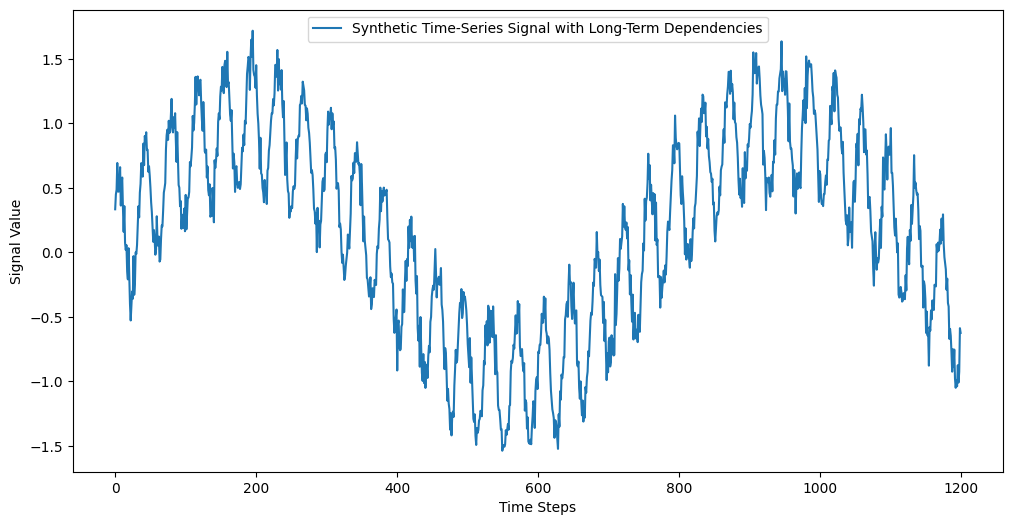

In [53]:
experiment.generate_long_term_dependency_signal(sequence_length=1200)
experiment.visualize_signal()

In [54]:
experiment.scale_signal()


In [55]:
dataloader = experiment.create_dataloader(input_size=6, batch_size=32)


### 4. Create RNN and Run Model for differnt hidden sizes:


Training model, hidden size: 5
Epoch 0, Loss: 0.2505
Epoch 5, Loss: 0.0813
Epoch 10, Loss: 0.0380
Epoch 15, Loss: 0.0238
Epoch 20, Loss: 0.0049
Epoch 25, Loss: 0.0044

Training model, hidden size: 4
Epoch 0, Loss: 0.1988
Epoch 5, Loss: 0.0550
Epoch 10, Loss: 0.0478
Epoch 15, Loss: 0.0428
Epoch 20, Loss: 0.0370
Epoch 25, Loss: 0.0310

Training model, hidden size: 3
Epoch 0, Loss: 1.7250
Epoch 5, Loss: 0.7270
Epoch 10, Loss: 0.2099
Epoch 15, Loss: 0.0647
Epoch 20, Loss: 0.0491
Epoch 25, Loss: 0.0468

Training model, hidden size: 2
Epoch 0, Loss: 0.1383
Epoch 5, Loss: 0.0782
Epoch 10, Loss: 0.0689
Epoch 15, Loss: 0.0633
Epoch 20, Loss: 0.0598
Epoch 25, Loss: 0.0569


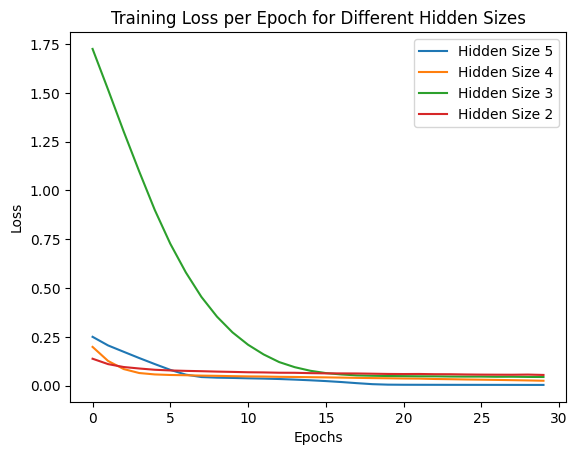

In [56]:
# loop over siezes
for hidden_size in range(5, 1, -1):
    print(f"\nTraining model, hidden size: {hidden_size}")
    
    # create model
    experiment.initialize_model(hidden_size=hidden_size, learning_rate=0.0005)
    
    # train
    epochs = 30 
    loss_per_epoch = []
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            experiment.optimizer.zero_grad()
            y_pred = experiment.model(x)
            loss = experiment.criterion(y_pred, y)
            loss.backward()
            experiment.optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_per_epoch.append(avg_loss)
        
        # track and print loss
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    
    plt.plot(loss_per_epoch, label=f"Hidden Size {hidden_size}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss per Epoch for Different Hidden Sizes")
plt.show()


### 5. Run models with different sizes and make predictions:


Evaluating model with hidden size: 5
Hidden Size 5 | Epoch 0, Loss: 0.1935
Hidden Size 5 | Epoch 10, Loss: 0.0067
Hidden Size 5 | Epoch 20, Loss: 0.0040

Results for Hidden Size 5


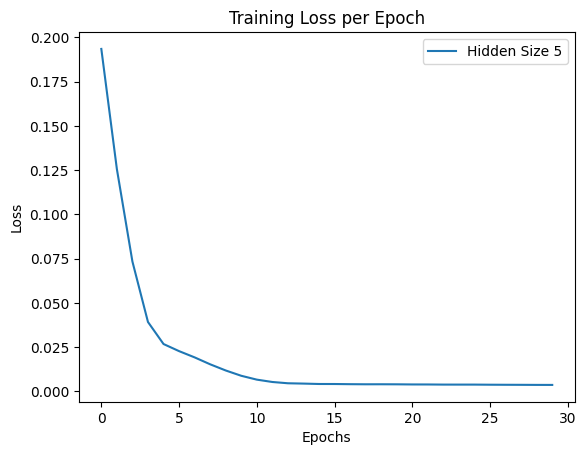

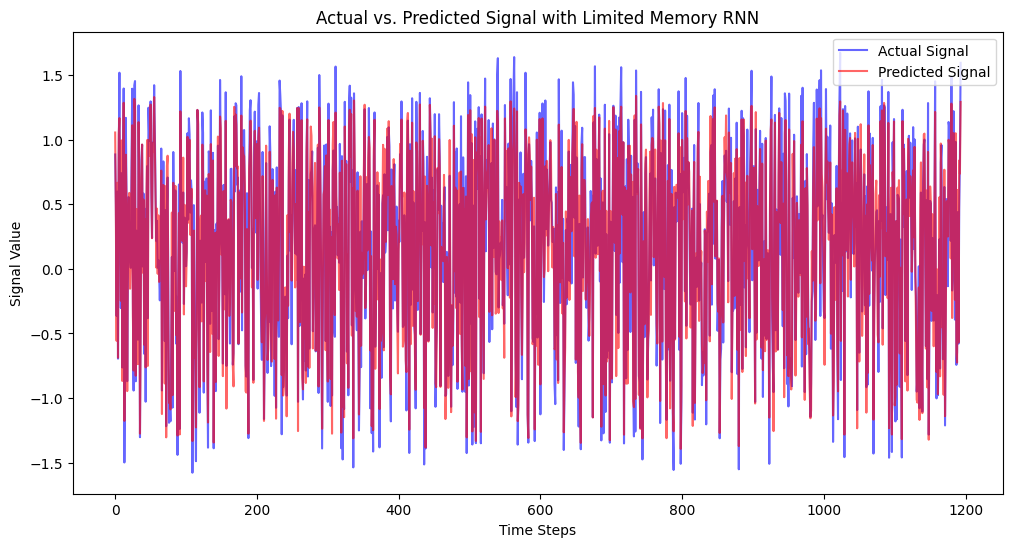


Evaluating model with hidden size: 4
Hidden Size 4 | Epoch 0, Loss: 0.1557
Hidden Size 4 | Epoch 10, Loss: 0.0234
Hidden Size 4 | Epoch 20, Loss: 0.0102

Results for Hidden Size 4


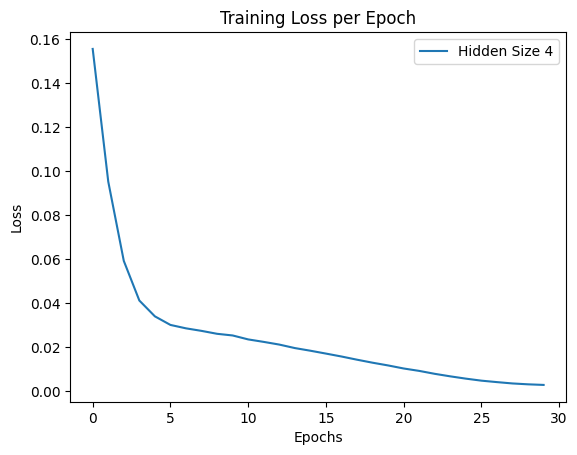

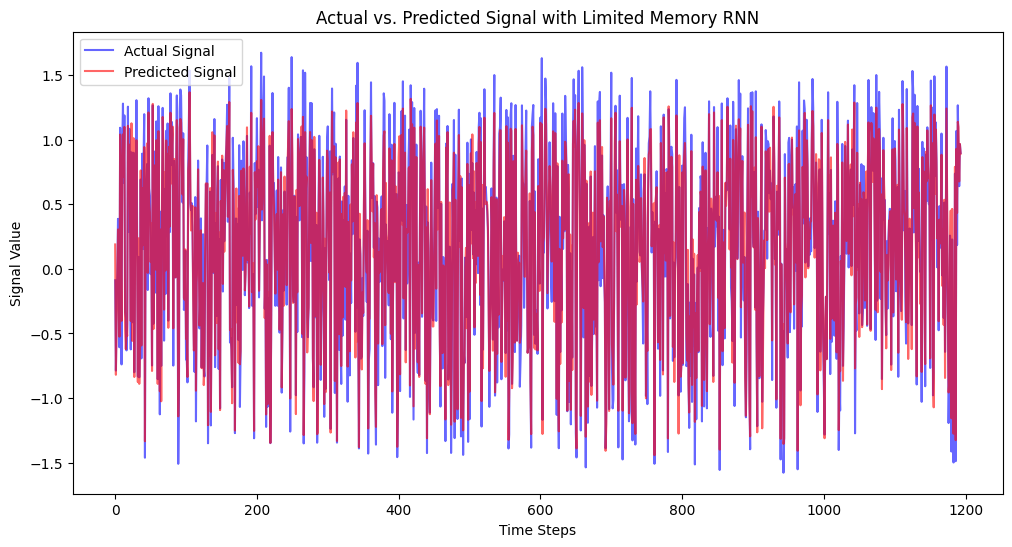


Evaluating model with hidden size: 3
Hidden Size 3 | Epoch 0, Loss: 0.0593
Hidden Size 3 | Epoch 10, Loss: 0.0271
Hidden Size 3 | Epoch 20, Loss: 0.0033

Results for Hidden Size 3


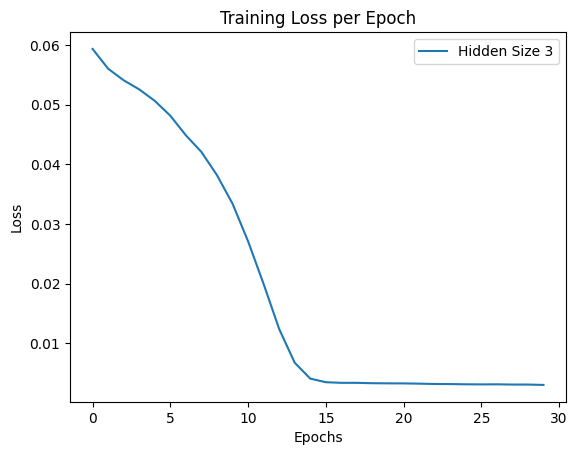

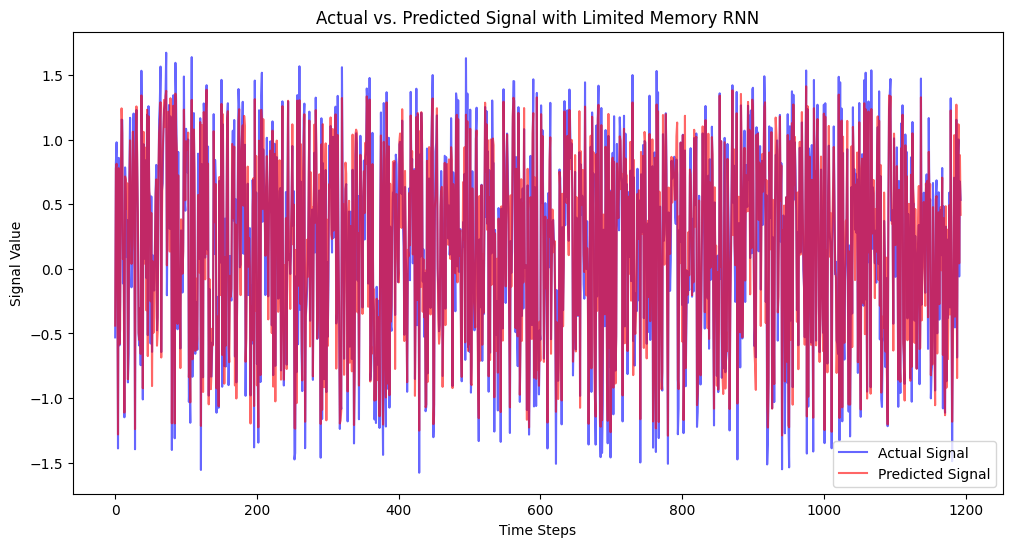


Evaluating model with hidden size: 2
Hidden Size 2 | Epoch 0, Loss: 1.8255
Hidden Size 2 | Epoch 10, Loss: 0.4262
Hidden Size 2 | Epoch 20, Loss: 0.0645

Results for Hidden Size 2


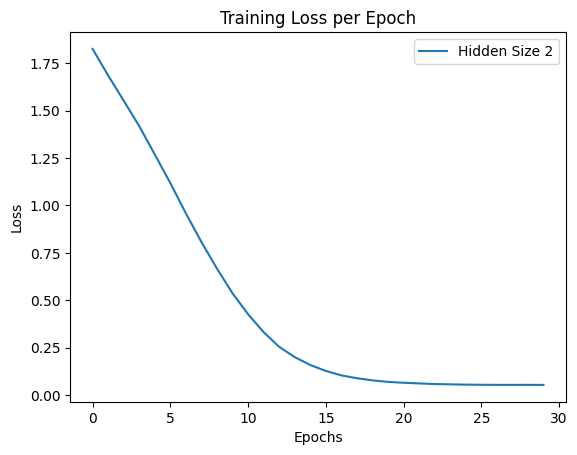

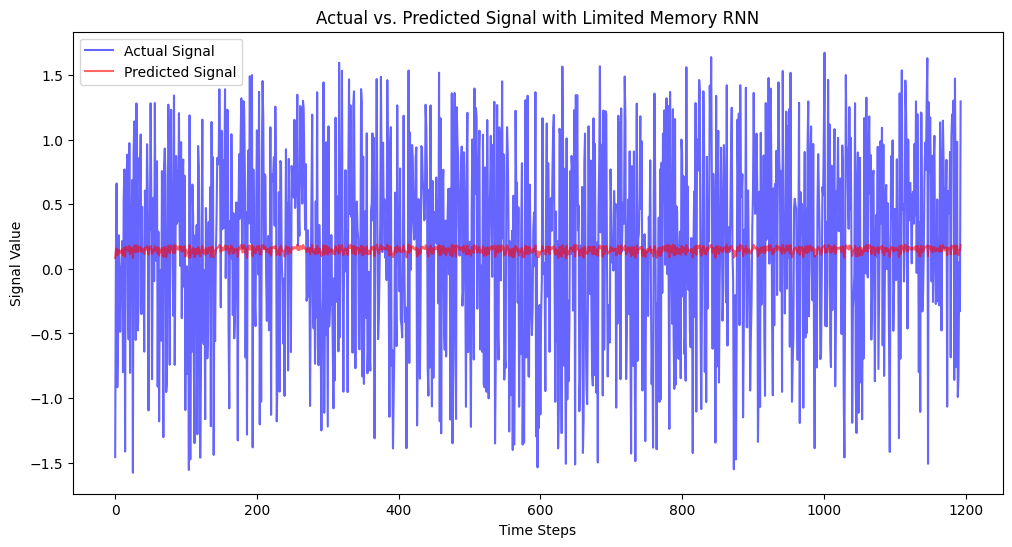

In [43]:
# loop over sizes and run
for hidden_size in range(5, 1, -1):
    print(f"\nEvaluating model with hidden size: {hidden_size}")
    experiment.initialize_model(hidden_size=hidden_size, learning_rate=0.0005)
    experiment.train_model(dataloader, hidden_size=hidden_size, epochs=30)
    predictions, actual = experiment.generate_predictions(dataloader)
    print(f"\nResults for Hidden Size {hidden_size}")
    experiment.visualize_results(predictions, actual)


### 6. Run Experiment for all and compare results:


Hidden Size 2 | Epoch 0, Loss: 0.7161
Hidden Size: 2, Epochs: 10, MSE: 0.0843
Hidden Size 2 | Epoch 0, Loss: 0.1689
Hidden Size 2 | Epoch 10, Loss: 0.0152
Hidden Size: 2, Epochs: 20, MSE: 0.0069
Hidden Size 2 | Epoch 0, Loss: 0.0529
Hidden Size 2 | Epoch 10, Loss: 0.0452
Hidden Size 2 | Epoch 20, Loss: 0.0121
Hidden Size: 2, Epochs: 30, MSE: 0.0032
Hidden Size 3 | Epoch 0, Loss: 0.0593
Hidden Size: 3, Epochs: 10, MSE: 0.0312
Hidden Size 3 | Epoch 0, Loss: 0.0607
Hidden Size 3 | Epoch 10, Loss: 0.0496
Hidden Size: 3, Epochs: 20, MSE: 0.0413
Hidden Size 3 | Epoch 0, Loss: 0.0549
Hidden Size 3 | Epoch 10, Loss: 0.0434
Hidden Size 3 | Epoch 20, Loss: 0.0137
Hidden Size: 3, Epochs: 30, MSE: 0.0025
Hidden Size 4 | Epoch 0, Loss: 0.0575
Hidden Size: 4, Epochs: 10, MSE: 0.0153
Hidden Size 4 | Epoch 0, Loss: 0.1113
Hidden Size 4 | Epoch 10, Loss: 0.0137
Hidden Size: 4, Epochs: 20, MSE: 0.0029
Hidden Size 4 | Epoch 0, Loss: 0.7781
Hidden Size 4 | Epoch 10, Loss: 0.0335
Hidden Size 4 | Epoch 20, 

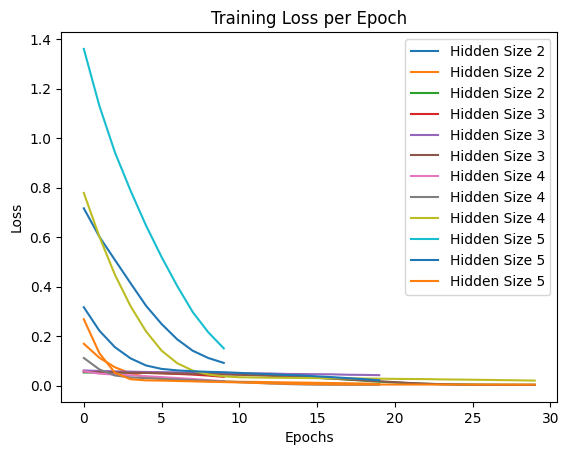

In [49]:
experiment = TimeSeriesRNNExperiment(sequence_length=1200, input_size=6, batch_size=32, learning_rate=0.0005)
experiment.generate_long_term_dependency_signal(sequence_length=1200)
experiment.scale_signal()
df_results = experiment.evaluate_model_across_hidden_sizes(hidden_sizes=[2, 3, 4, 5], epochs_list=[10, 20, 30])
print(df_results)

### 7. Conclusion:

- when it comes to the observation that there was high MSE at the largest memory, we can see that even with the maximum hidden size of 5 and 30 epochs the RNN model achieves an MSE of 0.0037 showing it cannot fully learn the signal's dependencies.

- However, we notice that there is inconsistent MSE in the hidden layers. The MSE values fluctuate across different hidden sizes and epochs showing that increasing the memory sizes does not reliably improve the model's ability to capture long-term dependencies.

- One noticeable item is that there is error at smaller hidden sizes. For hidden sizes of 2 and 3, the MSE remains relatively high across all epochs showing that smaller memory sizes are insufficient to capture the long-term patterns.

- With the higher hidden sizes we cna see that the MSE does not decrease consistently showing that the model's difficulty in learning the complex dependencies even with increased memory

- Overall across all memory sizes tested, the RNN had problems to consistently lower the MSE given the constraints, supporting the conclusion that the signal complexity surpasses the RNN's memory capacity. We can see this clearly with the overlap in the outputs of the model above.